In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline

import sys
#sys.path.append('/storage2/andrey/code/vrAnalysis/')
sys.path.append('/home/sobolev/storage2/andrey/code/vrAnalysis/')

import os
import h5py
#import nbimporter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.pyplot import figure
from scipy import stats as scipystats
from scipy import signal, interpolate
from mpl_toolkits.axes_grid1 import make_axes_locatable


from analysis.plots.utils import get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks, get_params_from_json
from analysis.processing.metrics import get_fields_between_epochs, get_field_pairs, get_lonely_fields
from analysis.adapters.hdf5 import H5NAMES

/home/sobolev/projects/pySIT/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Get sessions

In [4]:
COLORS = get_colors()

#storage_path = '/home/andrey/storage2'
#storage_path = '/storage2'
storage_path = '/home/sobolev/storage2'

source = os.path.join(storage_path, 'andrey/data/processed')
assets = os.path.join(storage_path, 'andrey/data/projects/24_shift/assets')
paper =  os.path.join(storage_path, 'andrey/data/projects/24_shift/PAPER')
bad_clu_dir = os.path.join(storage_path, 'andrey/data/projects/24_shift/bad_clusters')

animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363', '005364']  # all
animals = ['00908', '00910', '003281', '003282', '003908', '003909', '005363', '005364']  # no 002784
#animals = ['00908', '00910', '003281', '003282', '003909', '005363', '005364']
#animals = ['003281', '003282']

In [5]:
s_list_periodic_light = get_sessions_list(source, animals, 'SHIFT periodic')
s_list_periodic_dark = get_sessions_list(source, animals, 'SHIFT periodic +dark')
s_list_periodic_all = list(s_list_periodic_light) + list(s_list_periodic_dark)

s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
s_list_all = list(s_list_single) + list(s_list_periodic_all)
s_list_with_dark = list(s_list_single) + list(s_list_periodic_dark)

len(s_list_all), len(s_list_with_dark)

(99, 52)

In [7]:
# lonely fields
#lonely_A_B_all = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_all if rec is not None])
lonely_A_B = pd.concat([get_lonely_fields(source, rec[0], rec[1], 'A', 'B') for rec in s_list_with_dark if rec is not None])

No required H5 file found for 2020-10-23_12-57-03


In [8]:
print(list(shift_A_B_all))

['animal', 'session', 'electrode', 'unit', 'field_A', 'field_B', 'overlap_norm', 'sic_A', 'sic_B', 'isol_dist', 'peak_FR_A', 'peak_FR_B', 'COMa_x', 'COMa_y', 'COMb_x', 'COMb_y', 'shift', 'size_A', 'size_B']


# Filters

## Bad fields

- information content > 0.2
- peak firing rate > 1.5Hz
- isolation distance > 15

In [21]:
def get_idxs_by_quality(dataset, sicA=0.2, pfrA=1.5, sicB=0.2, pfrB=1.5, iso=15):
    # sic > 0.2, peak firing rate > 1.5 Hz, isolation distance > 15
    idxs_sic = (dataset['sic_A'] > sicA) & (dataset['sic_B'] > sicB)
    idxs_pfr = (dataset['peak_FR_A'] > pfrA) & (dataset['peak_FR_B'] > pfrB)
    idxs_iso = (dataset['isol_dist'] > iso)
    return idxs_sic & idxs_pfr & idxs_iso

In [22]:
def get_idxs_by_shift_range(dataset, s_min, s_max):
    return (dataset['shift'] > s_min) & (dataset['shift'] < s_max)

In [23]:
def get_idxs_of_good_clu(ds):
    col_types = {'animal': str, 'session': str, 'electrode': int, 'unit': int}
    bad_clu = pd.read_csv(os.path.join(bad_clu_dir, 'all.csv'), dtype=col_types)
    
    all_idxs = np.array(ds.index.tolist())
    df = ds.copy()
    df['idxs'] = all_idxs
    
    bad_idxs = np.array(df.merge(bad_clu, on=['animal', 'session', 'electrode', 'unit'], how='inner')['idxs'])
    return np.isin(all_idxs, bad_idxs, invert=True)

## Get field pairs

In [34]:
# or a single session
# sessions = [
#     ['003282', '2019-11-06_22-36-07'],
#     ['003282', '2019-11-18_10-35-43'],
# ]

# All shifts for all sessions in LIGHT
shift_A_B_all = get_fields_between_epochs(source, s_list_all, 'A', 'B')

# sessions with DARK present
shift_A_B = get_fields_between_epochs(source, s_list_with_dark, 'A', 'B')
shift_A_Ad = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Ad')
shift_B_Bd = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Bd')
shift_Ad_Bd = get_fields_between_epochs(source, s_list_with_dark, 'Ad', 'Bd')
shift_A_Bd = get_fields_between_epochs(source, s_list_with_dark, 'A', 'Bd')
shift_B_Ad = get_fields_between_epochs(source, s_list_with_dark, 'B', 'Ad')

No required H5 file found for 2020-10-23_12-57-03
PF match found for 1520 fields from total 3046 A and 3032 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 796 fields from total 1553 A and 1551 B fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 717 fields from total 1491 A and 1549 Ad fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 725 fields from total 1469 B and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 685 fields from total 1530 Ad and 1438 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 637 fields from total 1474 A and 1441 Bd fields
No required H5 file found for 2020-10-23_12-57-03
PF match found for 706 fields from total 1484 B and 1545 Ad fields


In [35]:
shift_A_B   = shift_A_B[get_idxs_of_good_clu(shift_A_B)]
shift_A_B   = shift_A_B[get_idxs_by_quality(shift_A_B)]
shift_A_Ad  = shift_A_Ad[get_idxs_of_good_clu(shift_A_Ad)]
shift_A_Ad  = shift_A_Ad[get_idxs_by_quality(shift_A_Ad, pfrB=0.1)]
shift_B_Ad  = shift_B_Ad[get_idxs_of_good_clu(shift_B_Ad)]
shift_B_Ad  = shift_B_Ad[get_idxs_by_quality(shift_B_Ad, pfrB=0.1)]
shift_B_Bd  = shift_B_Bd[get_idxs_of_good_clu(shift_B_Bd)]
shift_B_Bd  = shift_B_Bd[get_idxs_by_quality(shift_B_Bd, pfrB=0.1)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_of_good_clu(shift_Ad_Bd)]
shift_Ad_Bd = shift_Ad_Bd[get_idxs_by_quality(shift_Ad_Bd, pfrA=0.1, pfrB=0.1)]

In [191]:
# trying to use this dataset for all
df_AB   = shift_A_B.add_prefix('ab_')
df_BAd  = shift_B_Ad.add_prefix('bad_')
df_AdBd = shift_Ad_Bd.add_prefix('adbd_')
df_AAd  = shift_A_Ad.add_prefix('aad_')
df_BBd  = shift_B_Bd.add_prefix('bbd_')


# via AB -> BAd -> AdBd
df_ABBd = df_AB.merge(df_BAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
       right_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_A'], how='inner')
df_f4 = df_ABBd.merge(df_AdBd, left_on=['bad_animal', 'bad_session', 'bad_electrode', 'bad_unit', 'bad_field_B'], \
       right_on=['adbd_animal', 'adbd_session', 'adbd_electrode', 'adbd_unit', 'adbd_field_A'], how='inner')

# via AB -> AAd -> AdBd
df_ABBd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
        right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')
df_f4 = df_ABBd.merge(df_AdBd, left_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_B'], \
        right_on=['adbd_animal', 'adbd_session', 'adbd_electrode', 'adbd_unit', 'adbd_field_A'], how='inner')

# OPTION 2 filter above by merging with A-Ad
#df_f4 = df_ABAdBd.merge(df_AAd, \
#   left_on =['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A', 'bad_field_B'], \
#   right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A', 'aad_field_B'], how='inner')

# OPTION 3 filter above by merging with B-Bd
# df_f4 = df_f3.merge(df_BBd, \
#    left_on =['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B', 'adbd_field_B'], \
#    right_on=['bbd_animal', 'bbd_session', 'bbd_electrode', 'bbd_unit', 'bbd_field_A', 'bbd_field_B'], how='inner')


# OPTION 4 select stable fields via A-Ad
# df_ABAd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
#         right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')


# STABLE
stable = df_f4[['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_shift', 'aad_shift',\
               'ab_peak_FR_A', 'ab_peak_FR_B', 'adbd_peak_FR_A', 'adbd_peak_FR_B', 'ab_COMa_x', 'ab_COMa_y',\
               'ab_COMb_x', 'ab_COMb_y']]
stable['adbd_peak_FR_MEAN'] = (stable['adbd_peak_FR_A'] + stable['adbd_peak_FR_B']) / 2
stable['ab_shift_X'] = stable['ab_COMb_x'] - stable['ab_COMa_x']

stable = stable.rename(columns={
    'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'adbd_peak_FR_A': 'peak_FR_Ad', \
    'adbd_peak_FR_B': 'peak_FR_Bd', 'adbd_peak_FR_MEAN': 'peak_FR_D', 'ab_COMa_y': 'COMa_y',\
    'ab_shift': 'ab_shift_Y'})


# REMAPPED
remapping = df_AB.merge(df_f4, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
                     right_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
                     how="outer", indicator=True)
remapping = remapping[remapping['_merge'] == 'left_only']
remapping = remapping.rename(columns={'ab_shift_x': 'ab_shift_Y'})
remapping['ab_shift_X'] = remapping['ab_COMb_x_x'] - remapping['ab_COMa_x_x']


# select interesting columns for firing rate analysis
#rates = df_ABAdBd[['ab_peak_FR_A', 'ab_peak_FR_B', 'adbd_peak_FR_A', 'adbd_peak_FR_B', 'ab_shift', 'ab_COMa_y']]
#rates = rates.rename(columns={
#    'ab_peak_FR_A': 'peak_FR_A', 'ab_peak_FR_B': 'peak_FR_B', 'adbd_peak_FR_A': 'peak_FR_Ad', \
#    'adbd_peak_FR_B': 'peak_FR_Bd', 'ab_shift': 'shift', 'ab_COMa_y': 'COMa_y'})

#print('Stable: %s, rates: %s' % (len(stable), len(rates)))
print('Stable: %s, remapped: %s' % (len(stable), len(remapping)) )

Stable: 276, remapped: 185


/tmp/ipykernel_408876/2114048277.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable['adbd_peak_FR_MEAN'] = (stable['adbd_peak_FR_A'] + stable['adbd_peak_FR_B']) / 2
/tmp/ipykernel_408876/2114048277.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stable['ab_shift_X'] = stable['ab_COMb_x'] - stable['ab_COMa_x']


## Remapping / stable

In [192]:
# # match stats
# match_both, match_both_X = [], []
# match_A_Ad, match_A_Ad_X = [], []
# match_B_Bd, match_B_Bd_X = [], []
# match_none, match_none_X = [], []
# match_none_idxs = []

# def get_match_idxs(dataset, row):
#     idxs_1 = (dataset['session'] == row['session'])
#     idxs_2 = (dataset['electrode'] == row['electrode'])
#     idxs_3 = (dataset['unit'] == row['unit'])
#     idxs_4 = (dataset['field_A'] == row['field_A'])
#     return idxs_1 & idxs_2 & idxs_3 & idxs_4

# ds_filt = shift_A_B.copy()
# #ds_filt = ds_filt[get_idxs_of_good_clu(ds_filt)]
# #ds_filt = ds_filt[get_idxs_by_quality(ds_filt)]
# for i, row in ds_filt.iterrows():
#     # for each matched pair in light (A, B) search for pair in dark (A, Ad and B, Bd)
#     idxs_A = get_match_idxs(shift_A_Ad, row)
#     idxs_B = get_match_idxs(shift_B_Bd, row)
    
#     if idxs_A.any() and idxs_B.any():
#         match_both.append(row['shift'])
#         match_both_X.append(row['COMb_x'] - row['COMa_x'])
#     elif idxs_A.any():
#         match_A_Ad.append(row['shift'])
#         match_A_Ad_X.append(row['COMb_x'] - row['COMa_x'])
#     elif idxs_B.any():
#         match_B_Bd.append(row['shift'])
#         match_B_Bd_X.append(row['COMb_x'] - row['COMa_x'])
#     else:
#         match_none.append(row['shift'])
#         match_none_X.append(row['COMb_x'] - row['COMa_x'])
                
#         #f_path = os.path.join(source, row['animal'], row['session'], 'analysis', 'placefields')
#         #f_name = '%s_%s_%s_%s.png' % (row['animal'], row['session'], row['electrode'], row['unit'])
#         #copyfile(os.path.join(f_path, f_name), os.path.join(dest, f_name))

[276, 185]


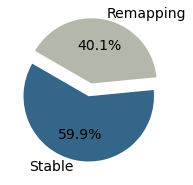

In [193]:
data = [len(stable), len(remapping)]
labels = 'Stable', 'Remapping'
colors = [COLORS['a'], COLORS['f'], COLORS['b']]
explode = (0, 0.2)

fig = figure(figsize=(3, 3))
ax = fig.add_subplot(111)

wedges, labels, autopct = ax.pie(data, explode=explode, colors=colors, labels=labels, \
             autopct='%1.1f%%', textprops={'fontsize': 14}, startangle=150)
for lab in labels:
    lab.set_fontsize(14)
    
print(data)    
filename = "2c.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

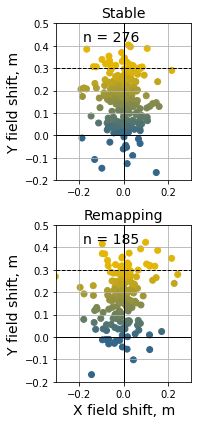

In [194]:
# stable / remapping as scatterplots

from common import colorFader

def get_color_for_shift(shift):
    if shift < 0:
        return COLORS['a']
    elif shift > 0.3:
        return COLORS['d']
    else:
        return colorFader(COLORS['a'], COLORS['d'], shift/0.3)

# stable_all     = -1 * (np.concatenate([np.array(match_both), np.array(match_A_Ad), np.array(match_B_Bd)]) - 0.3)
# stable_all_X   = np.concatenate([np.array(match_both_X), np.array(match_A_Ad_X), np.array(match_B_Bd_X)])
# unstable_all   = -1 * (np.array(match_none) - 0.3)
# unstable_all_X = np.array(match_none_X)

sta_Y = -1 * (stable['ab_shift_Y'] - 0.3)
sta_X = stable['ab_shift_X']
rem_Y = -1 * (remapping['ab_shift_Y'] - 0.3)
rem_X = remapping['ab_shift_X']

# plt.hist(-1 * (stable_all - 0.3), bins, color=COLORS['a'], density=True)
# plt.hist(-1 * (unstable_all - 0.3), bins, color=COLORS['f'], density=True, alpha=0.5)

bins = np.arange(-0.4, 0.6, 0.025)
colors = (COLORS['a'], COLORS['f'])
titles = ('Stable', 'Remapping')

fig = figure(figsize=(3, 6))
for i, (d_y, d_x) in enumerate([[sta_Y, sta_X], [rem_Y, rem_X]]):
    ax = fig.add_subplot(2, 1, i+1)
    ax.set_ylim(-0.2, 0.5)
    ax.set_xlim(-0.3, 0.3)
    clrs = [get_color_for_shift(shift) for shift in d_y]
    
    #ax.scatter(d_x[d_y < 0.1], d_y[d_y < 0.1], color=COLORS['a'], alpha=0.6)
    #ax.scatter(d_x[d_y > 0.1], d_y[d_y > 0.1], color=COLORS['d'], alpha=0.6)
    ax.scatter(d_x, d_y, c=clrs, lw=1)
    ax.axvline(0, color='black', lw=1)
    ax.axhline(0, color='black', lw=1)
    ax.axhline(0.3, color='black', ls='--', lw=1)
    if i > 0:
        ax.set_xlabel('X field shift, m', fontsize=14)
    ax.set_ylabel('Y field shift, m', fontsize=14)
    ax.text(-0.18, 0.42, 'n = %d' % len(d_y), fontsize=14)
    ax.set_title(titles[i], fontsize=14)
    ax.set_aspect('equal')
    ax.grid()

fig.tight_layout()

filename = "2d_1a.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

In [195]:
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from common import colorFaderRGB

c1 = COLORS['a']
c2 = COLORS['d']

colors = np.array([colorFaderRGB(c1, c2, x) for x in np.linspace(0, 1, 50)])
colors = np.column_stack([colors, np.ones(50)])

cmap = ListedColormap(colors, name='S5')

In [254]:
df = stable.copy()

# correct for diff ref frame
df['shift'] = (-1) * (df['ab_shift_Y'] - 0.3)

# compute distance to the nearest wall
def get_dist(COMa_ys):
    return np.min(np.column_stack([COMa_ys + 0.9, 0.7 - COMa_ys]), axis=1)

distances = get_dist(np.array(df['COMa_y']))
shifts = np.array(df['shift'])
x_vals = (df['peak_FR_A'] + df['peak_FR_B'])/2
y_vals = (df['peak_FR_Ad'] + df['peak_FR_Bd'])/2

# sort by shift for nicer plotting?
idxs_sort = np.argsort(shifts)
#idxs_sort = (-shifts).argsort()
distances = distances[idxs_sort]
shifts = shifts[idxs_sort]
x_vals = x_vals[idxs_sort]
y_vals = y_vals[idxs_sort]

9997.000, 0.00000


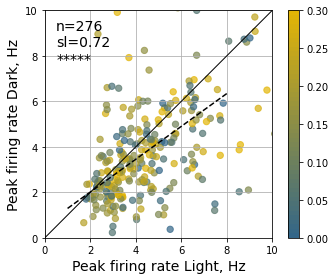

In [255]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4.))

diffs = y_vals - x_vals
slope, intercept, r_value, p_value, std_err = scipystats.linregress(x_vals, y_vals)
st, pv = scipystats.kruskal(x_vals, y_vals)
st, pv = scipystats.wilcoxon(x_vals, y_vals)

print("%.3f, %.5f" % (st, pv))


sizes = 40*np.ones(len(x_vals))
clrs = [get_color_for_shift(shift) for shift in np.array(df['shift'])]
#clrs = [colorFader(COLORS['a'], COLORS['d'], dist/0.8) for dist in distances]

r_max = 10
ax.set_xlim(0, r_max)
ax.set_ylim(0, r_max)
#ax.scatter(np.log(x_vals), np.log(y_vals), c=clrs, alpha=0.7, s=sizes)
im = ax.scatter(x_vals, y_vals, c=clrs, alpha=0.7, s=sizes)
ax.set_xlabel('Peak firing rate Light, Hz', fontsize=14)
ax.set_ylabel('Peak firing rate Dark, Hz', fontsize=14)
ax.plot([0, r_max], [0, r_max], color='black', lw=1)
ax.plot([1, 8], intercept + slope*np.array([1, 8]), color='black', lw=1.5, ls='--')
#ax.set_title(titles[i], fontsize=14)
ax.text(0.5, 7.7, 'n=%d\nsl=%.2f\n%s' % (len(y_vals), slope, '*****'), fontsize=14)
ax.grid()
ax.set_aspect('equal')

# https://stackoverflow.com/questions/43805821/matplotlib-add-colorbar-to-non-mappable-object
norm = mpl.colors.Normalize(vmin=0., vmax=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cb = fig.colorbar(sm, ax=ax)

fig.tight_layout()
filename = "2f.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))

0.0001220703125
0.1779801845550537
0.008848528462849805
0.010231135242361087
4.121700197216595e-06
0.008487856309587575
0.00214963303606519
0.05446250397189108


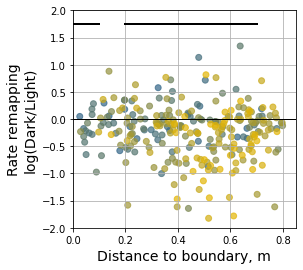

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

clrs = [get_color_for_shift(shift) for shift in shifts]

sl_rr, int_rr, _, pval_rr, _ = scipystats.linregress(distances, np.log(y_vals/x_vals))

ax.scatter(distances, np.log(y_vals/x_vals), c=clrs, alpha=0.7)
#ax.plot([0.05, 0.8], int_rr + sl_rr*np.array([0.05, 0.8]), color='black', lw=1.5, ls='--')

ax.axhline(0, color='black', lw=1)
ax.set_xlabel('Distance to boundary, m', fontsize=14)
ax.set_ylabel('Rate remapping\nlog(Dark/Light)', fontsize=14)
ax.set_xlim(0, 0.85)
ax.set_ylim(-2, 2)
ax.grid()

step = 0.1
l_height = 1.75
for x in np.arange(0, 0.8, step):
    idxs_filt = np.where((distances > x) & (distances < x + step))[0]
    st, pv = scipystats.wilcoxon(np.zeros(len(idxs_filt)), np.log(y_vals/x_vals)[idxs_filt])
    if pv < 0.05:
        ax.plot([x, x+step], [l_height, l_height], color='black', lw=2)
        
    print(pv)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75])

In [197]:
# s_list_single = get_sessions_list(source, animals, 'SHIFT single +dark')
# s_list_periodic = get_sessions_list(source, animals, 'SHIFT periodic +dark')
# s_comb = list(s_list_single) + (s_list_periodic)

# single, periodic, combined = {}, {}, {}
# for coll, lst in [[single, s_list_single], [periodic, s_list_periodic_dark], [combined, s_list_with_dark]]:
#     for cond_A, cond_B in [['A', 'B'], ['A', 'Ad'], ['B', 'Bd']]:
#         coll[cond_A + cond_B] = get_fields_between_epochs(source, lst, cond_A, cond_B)

# len(single['AB']), len(periodic['AB']), len(combined['AB'])

In [198]:
# df_AB  = combined['AB'][get_idxs_by_quality(combined['AB'])]
# df_AB = df_AB[get_idxs_of_good_clu(df_AB)]
# df_AAd = combined['AAd'][get_idxs_by_quality(combined['AAd'])]
# df_AAd = df_AAd[get_idxs_of_good_clu(df_AAd)]
# df_BBd = combined['BBd'][get_idxs_by_quality(combined['BBd'])]
# df_BBd = df_BBd[get_idxs_of_good_clu(df_BBd)]

# df_AB  = combined['AB']
# df_AAd = combined['AAd']
# df_BBd = combined['BBd']

# df_AB['shift'] = (-1) * (df_AB['shift'] - 0.3)
# df_AAd['shift'] = (-1) * (df_AAd['shift'] - 0.3)
# df_BBd['shift'] = (-1) * (df_BBd['shift'] - 0.3)

# df_AB   = df_AB.add_prefix('ab_')
# df_AAd  = df_AAd.add_prefix('aad_')
# df_BBd  = df_BBd.add_prefix('bbd_')

# df_ABAd = df_AB.merge(df_AAd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_A'], \
#        right_on=['aad_animal', 'aad_session', 'aad_electrode', 'aad_unit', 'aad_field_A'], how='inner')
# df_m = df_ABAd.merge(df_BBd, left_on=['ab_animal', 'ab_session', 'ab_electrode', 'ab_unit', 'ab_field_B'], \
#        right_on=['bbd_animal', 'bbd_session', 'bbd_electrode', 'bbd_unit', 'bbd_field_A'], how='inner')

# print(len(df_m))

57.1386434772172 4.061463478124616e-14


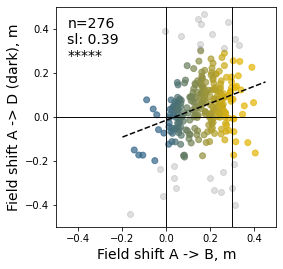

In [199]:
# df_00  = df_m[(df_m['ab_shift'] > grps['b'][0]) & (df_m['ab_shift'] < grps['b'][1])]
# #df_15 = df_m[(df_m['ab_shift'] > grps['h'][0]) & (df_m['ab_shift'] < grps['h'][1])]
# df_30  = df_m[(df_m['ab_shift'] > grps['v'][0]) & (df_m['ab_shift'] < grps['v'][1])]
#df_all = df_m.copy()
df_all = stable.copy()

fig = plt.figure(figsize=(4, 4))
colors = (COLORS['a'], COLORS['d'])

ax = fig.add_subplot(1, 1, 1)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.axvline(0, color='black', alpha=0.95, lw=1)
ax.axhline(0, color='black', alpha=0.95, lw=1)
ax.axvline(0.3, color='black', alpha=0.95, lw=1)
ax.set_aspect('equal')
ax.set_xlabel('Field shift A -> B, m', fontsize=14)
ax.set_ylabel('Field shift A -> D (dark), m', fontsize=14)
#ax.grid()
    
#x_vals = np.array(-1 * ( (df_all['ab_COMb_y'] - df_all['ab_COMa_y']) - 0.3 ))
#y_vals = np.array(-1 * (df_all['aad_COMb_y'] - df_all['ab_COMa_y']))
x_vals = np.array(-1 * ( (df_all['ab_shift_Y']) - 0.3 ))
y_vals = np.array(-1 * ( (df_all['aad_shift']) ))

st, pv = scipystats.kruskal(y_vals, np.zeros(len(y_vals)))
print(st, pv)

idxs_in  = np.where((y_vals > -0.2) & (y_vals < 0.3))[0]
idxs_out = np.where((y_vals < -0.2) | (y_vals > 0.3))[0]
clrs = [get_color_for_shift(shift) for shift in x_vals[idxs_in]]

ax.scatter(x_vals[idxs_in], y_vals[idxs_in], c=clrs, alpha=0.7)
ax.scatter(x_vals[idxs_out], y_vals[idxs_out], color='grey', alpha=0.25)
#ax.axvline(np.median(x_vals), ls='--', color=colors[i])
#ax.axhline(np.median(y_vals), ls='--', color=colors[i])
#ax.set_title('st=%.2f, p=%.4f' % (st, pv), fontsize=14)
#txt = '*****' if pv < 0.001 else 'n.s.'

#x_all = np.array(-1 * ((df_all['ab_COMb_y'] - df_all['ab_COMa_y']) - 0.3 ))
#y_all = np.array(-1 * (df_all['aad_COMb_y'] - df_all['ab_COMa_y']))
slope, intercept, r_value, p_value, std_err = scipystats.linregress(x_vals, y_vals)
x_to_plot = np.array([-0.2, 0.45])
ax.plot(x_to_plot, intercept + slope*x_to_plot, color='black', alpha=0.99, ls='--')
ax.text(-0.45, 0.36 - 0.1*i, 'n=%d\nsl: %.2f\n*****' % (len(y_vals), slope), fontsize=14, color='black')
#ax.text(-0.4, -0.2, "sl: %.2f\np: *****" % slope, fontsize=14)


fig.tight_layout()
filename = "2g_l.pdf"
#fig.savefig(os.path.join(os.path.join(paper), filename))